<a href="https://colab.research.google.com/github/robinvloeberghs/Dynamax/blob/main/Hierarchical_Bernoulli_LDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# (Hierarchical) Bernoulli LDS Model

\begin{align*}
x_t &\sim \mathcal{N}(a x_{t-1}, \eta^2) \\
y_t &\sim \mathrm{Bern}(\sigma(w^\top u_t + x_t)) 
\end{align*}

where $x_t \in \mathbb{R}$ are the latent shift in the decision criterion, and $u_t = (1, \ldots)$ are a vector of covariates that always include a bias.

The parameters are $\theta = (a, \eta, w)$. We want to estimate them via maximum likelihood estimation. 

## Strategy

Use conditional moments Gaussian filter (CMGF) to estimate the posterior distribution $p(x_{1:T} \mid y_{1:T}, \theta)$, as well as the marginal likelihood $p(y_{1:T} \mid \theta)$. 

Then we can perform maximum likelihood estimation by gradient ascent on the marginal likelihood. 

In order to use CMGF we need the conditional moments of the emissions. Those are in closed form,

\begin{align*}
\mathbb{E}[y_t \mid x_t] &= \sigma(w^\top u_t + x_t) \\
\mathbb{V}[y_t \mid x_t] &= \sigma(w^\top u_t + x_t) (1 - \sigma(w^\top u_t + x_t))
\end{align*}

To do:
- Generate data with different params for each dataset
- Calculate mean and variance over subjects parameters on each iteration to calculate hierarchical priors
- Add hierarchical priors to objective
- Implement procedure for weighted group average (and variance) based on Laplace approximation (covariance matrix = inverse of negative Hessian)



In [32]:
%%capture 
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    !pip install git+https://github.com/probml/dynamax.git#egg=dynamax
    import dynamax

In [33]:
%%capture 
try:
    import optax
except ModuleNotFoundError:
    print('installing optax')
    !pip install optax
    import optax

In [34]:
from functools import partial

from jax import vmap, grad, value_and_grad, lax
from jax import numpy as jnp
from jax import random as jr
from jax.nn import softplus, sigmoid
from jax import scipy
from matplotlib import pyplot as plt
import numpy as np


from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions


from dynamax.generalized_gaussian_ssm import ParamsGGSSM, GeneralizedGaussianSSM, EKFIntegrals
from dynamax.generalized_gaussian_ssm import conditional_moments_gaussian_smoother


## First initialize a model and sample from it

In [35]:
input_dim = 7
state_dim = 1
emission_dim = 1


true_params = dict(A=jnp.eye(state_dim),
                   unc_eta=jnp.zeros(state_dim),
                   w=jr.normal(jr.PRNGKey(1), (input_dim,)))

def initialize_params(key):
    # Randomly initialize parameters for fitting
    key1, key2, key3 = jr.split(key, 3)
    A = jnp.diag(tfd.Beta(10.0, 1.0).sample(seed=key1, sample_shape=(state_dim,)))
    unc_eta = tfd.Normal(0.0, 1.0).sample(seed=key2, sample_shape=(state_dim,))
    w = tfd.Normal(0.0, 1.0).sample(seed=key3, sample_shape=(input_dim,))
    return dict(A=A, unc_eta=unc_eta, w=w)


def make_model(params):
    model_params = ParamsGGSSM(
        initial_mean=jnp.zeros(state_dim),
        initial_covariance=jnp.eye(state_dim),
        dynamics_function=lambda x, u: params["A"] @ x,
        dynamics_covariance=jnp.diag(1e-1 + softplus(params["unc_eta"])), # parameterize eta as diag(softplus(unc_eta))
        emission_mean_function=lambda x, u: sigmoid(params["w"] @ u + x),
        emission_cov_function=lambda x, u: jnp.diag(
            1e-4 + sigmoid(params["w"] @ u + x) * sigmoid(-(params["w"] @ u + x))), 
        emission_dist=lambda mu, Sigma: tfd.Bernoulli(probs=jnp.clip(mu, 1e-4, 1-1e-4))
    )
    model = GeneralizedGaussianSSM(state_dim, emission_dim)
    return model, model_params


In [36]:
num_sessions = 3
num_timesteps = 1000     # length of each session

def sample_one(key, params):
    # Convert the trainable params into a GGSSM and its params
    model, model_params = make_model(params)

    # Sample random inputs (make sure first entry is a bias)
    this_key, key = jr.split(key)
    inputs = tfd.Normal(0, 1).sample(seed=this_key, sample_shape=(num_timesteps, input_dim))
    inputs = inputs.at[:, 0].set(1.0)

    # Sample states and emissions given inputs and model params
    this_key, key = jr.split(key)
    states, emissions = model.sample(model_params, num_timesteps=num_timesteps, key=key, inputs=inputs)
    return inputs, states, emissions

all_inputs, all_states, all_emissions = \
    vmap(partial(sample_one, params=true_params))(
        jr.split(jr.PRNGKey(0), num_sessions))

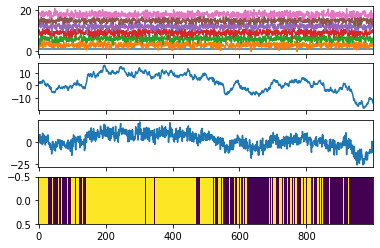

In [37]:
def plot_session(index, params):
    inputs = all_inputs[index]
    states = all_states[index]
    emissions = all_emissions[index]

    fig, axs = plt.subplots(4, 1, sharex=True)
    axs[0].plot(inputs + 3 * jnp.arange(input_dim))
    axs[1].plot(states)
    axs[2].plot(inputs @ params["w"] + states[:, 0])
    axs[3].imshow(emissions.T, aspect="auto", interpolation="none")

plot_session(0, true_params)

## Approximate the posterior with CMGF

In [38]:
def compute_posterior(params, inputs, emissions):
    model, model_params = make_model(params)
    posterior = conditional_moments_gaussian_smoother(
        model_params, EKFIntegrals(), emissions, inputs=inputs) # conditional moments of the emissions in model_params
    return posterior


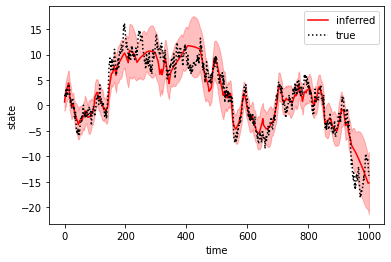

In [39]:
def plot_posterior(params, index):
    inputs = all_inputs[index]
    states = all_states[index]
    emissions = all_emissions[index]

    posterior = compute_posterior(params, inputs, emissions)
    smoothed_mean = posterior.smoothed_means[:, 0]
    smoothed_std = jnp.sqrt(posterior.smoothed_covariances[:, 0, 0])

    plt.fill_between(jnp.arange(num_timesteps), 
                    smoothed_mean - 2 * smoothed_std,
                    smoothed_mean + 2 * smoothed_std, color='r', alpha=0.25)
    plt.plot(posterior.smoothed_means, color='r', label="inferred")
    plt.plot(states, ':k', label="true")
    plt.xlabel("time")
    plt.ylabel("state")
    plt.legend()

plot_posterior(true_params, 0)
    

posterior = compute_posterior(true_params,all_inputs[0], all_emissions[0])



## Optimize the parameters by gradient descent

In [142]:
def subject_objective(params, subject_index):
    posteriors = compute_posterior(params, all_inputs[subject_index], all_emissions[subject_index])

    return -posteriors.marginal_loglik.mean() / num_timesteps



    ### work in progress
    #group_mean_w = 0
    #group_std_w = 2
    #log_likelihood = scipy.stats.norm.pdf(fit_params['w'][0], loc=group_mean_w, scale=group_std_w)
    #log_likelihood = scipy.stats.norm.pdf(params['A'], loc=group_mean_A, scale=group_std_A) # scale = std
    #return -posterior.marginal_loglik.mean() / num_timesteps

#objective(true_params)


#group_mean_w = 0
#group_std_w = 2
#log_likelihood = scipy.stats.norm.pdf(fit_params['w'][0], loc=group_mean_w, scale=group_std_w)


In [143]:
def run_gradient_descent(subject_objective, init_params, all_inputs, all_emissions, optimizer=optax.adam(1e-2), num_steps=5):

    num_subjects = len(all_inputs)
    params_list = [init_params for _ in range(num_subjects)] # first start with initialized params, then overwrite with estimated params each iteration
    optimizer_state_list = [optimizer.init(params) for params in params_list]
    losses_list = [[] for _ in range(num_subjects)]

    # Minimize the negative expected log joint with gradient descent for each dataset
    for step in range(num_steps):
        print("Iteration:" + str(step))

        for i in range(num_subjects):
            print("Subject:" + str(i))
  
            # Load output of previous iteration of subject i
            params = params_list[i]
            optimizer_state = optimizer_state_list[i]
            loss_grad_fn = value_and_grad(subject_objective)

            # One step of the algorithm for this dataset
            def train_step(carry, args):
                params, optimizer_state = carry
                loss, grads = loss_grad_fn(params, i)
                updates, optimizer_state = optimizer.update(grads, optimizer_state)
                params = optax.apply_updates(params, updates)
                return (params, optimizer_state), loss

            # Run the optimizer for this dataset (1 step)
            # Idea for optimization fitting time: https://flax.readthedocs.io/en/latest/_modules/flax/jax_utils.html see def scan_in_dim
            # Allows to do each iteration over subjects in parallel?
            initial_carry = (params, optimizer_state)
            (params, optimizer_state), losses = lax.scan(train_step, initial_carry, None, length=1)

            # Save output for next iteration
            params_list[i] = params
            optimizer_state_list[i] = optimizer_state
            losses_list[i].append(losses[0])
            print(params)
            #print(losses)

        # Create empty arrays to store the values
        A_values = []
        unc_eta_values = []
        w_values = []

        # Save parameter value of each subject to list
        for params in params_list:
            A_values.append(params['A'])
            unc_eta_values.append(params['unc_eta'])
            w_values.append(params['w'])

        # Take mean of each parameter over subjects
        mean_A = np.mean(A_values)
        mean_unc_eta = np.mean(unc_eta_values)
        mean_w = np.mean(w_values, axis=0)

        mean_params = {'A': mean_A, 'unc_eta': mean_unc_eta, 'w': mean_w}

    return params_list, optimizer_state_list, losses_list, mean_params

In [ ]:
# Run gradient descent
init_params = initialize_params(jr.PRNGKey(0)) # let this vary per subject?
params_list, _, losses_list, mean_params = run_gradient_descent(subject_objective, init_params, all_inputs, all_emissions)

Iteration:0
Subject:0
{'A': Array([[0.9044642]], dtype=float32), 'unc_eta': Array([0.56814885], dtype=float32), 'w': Array([-0.3753745 , -1.4607389 ,  0.53679204, -0.13828664,  1.1065618 ,
        0.15117477, -0.5471373 ], dtype=float32)}
Subject:1
{'A': Array([[0.9044642]], dtype=float32), 'unc_eta': Array([0.5881487], dtype=float32), 'w': Array([-0.39537436, -1.4607389 ,  0.53679204, -0.13828664,  1.1065618 ,
        0.15117477, -0.52713746], dtype=float32)}
Subject:2
{'A': Array([[0.9044642]], dtype=float32), 'unc_eta': Array([0.5881487], dtype=float32), 'w': Array([-0.39537436, -1.4607389 ,  0.53679204, -0.13828664,  1.1065617 ,
        0.15117478, -0.52713746], dtype=float32)}
Iteration:1
Subject:0
{'A': Array([[0.9144083]], dtype=float32), 'unc_eta': Array([0.5581711], dtype=float32), 'w': Array([-0.36542305, -1.4507407 ,  0.5267926 , -0.12828828,  1.0965706 ,
        0.14117852, -0.5571365 ], dtype=float32)}
Subject:1
{'A': Array([[0.91445965]], dtype=float32), 'unc_eta': Array(

In [ ]:
plt.plot(losses, label="fit")
plt.axhline(objective(true_params), ls=':', color='k', label="true")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()

In [ ]:
# Compare true and inferred params
jnp.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

for key in ["A", "unc_eta", "w"]:
    print(key)
    print("true:", true_params[key])
    print("init:", init_params[key])
    print("fit: ", fit_params[key])
    print()

In [ ]:
plot_posterior(fit_params, 0)
plt.title("posterior with fit params")

In [ ]:
plot_posterior(true_params, 0)
plt.title("posterior with true params")